In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/imdb-50k-movie-reviews-test-your-bert/train.csv
/kaggle/input/imdb-50k-movie-reviews-test-your-bert/test.csv


In [2]:
import sys
import numpy as np
import random as rn
import pandas as pd
import torch
from pytorch_pretrained_bert import BertModel
from torch import nn
# from torchnlp.datasets import imdb_dataset      # --> We are using our own uploaded dataset.
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Initializing seed values to stabilize the outcomes.

In [3]:
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)

## Prepare the data

In [4]:
path = '../input/imdb-50k-movie-reviews-test-your-bert/'

train_data = pd.read_csv(path + 'train.csv')
test_data = pd.read_csv(path + 'test.csv')

In [5]:
# experimenting here with a sample of dataset, to avoid memory overflow.
train_data = train_data[:2000]
test_data = test_data[:500]

train_data = train_data.to_dict(orient='records')
test_data = test_data.to_dict(orient='records')
type(train_data)

list

### Mapping sentences with their Labels...

In [6]:
train_texts, train_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), train_data)))
test_texts, test_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), test_data)))

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(2000, 2000, 500, 500)

#### visualizing one of the sentences from train set

In [7]:
train_texts[0]

"Now, I won't deny that when I purchased this off eBay, I had high expectations. This was an incredible out-of-print work from the master of comedy that I so enjoy. However, I was soon to be disappointed. Apologies to those who enjoyed it, but I just found the Compleat Al to be very difficult to watch. I got a few smiles, sure, but the majority of the funny came from the music videos (which I've got on DVD) and the rest was basically filler. You could tell that this was not Al's greatest video achievement (that honor goes to UHF). Honestly, I doubt if this will ever make the jump to DVD, so if you're an ultra-hardcore Al fan and just HAVE to own everything, buy the tape off eBay. Just don't pay too much for it."

## visualizing sentences lengths

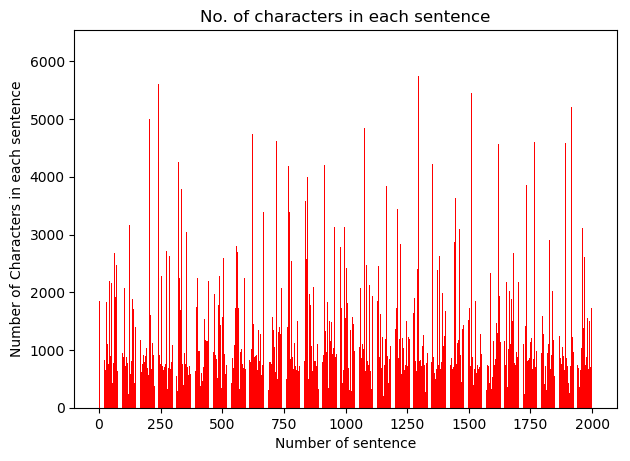

In [8]:
sentences = [len(sent) for sent in train_texts]

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1,2001), sentences, color = ['red'])
plt.gca().set(title='No. of characters in each sentence', xlabel='Number of sentence', ylabel='Number of Characters in each sentence');

#### We can see that most of the sentences are around 700 - 1000 characters long, which is pretty obvious. HOwever, few sentences are shorter and few even long as 6000 characters. So, this is a good, very versatile Review Dataset.

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 3765667.15B/s]


### Sample of how BERT Tokenizer works and Embeddings prepared to be fed into BERT Model.

![BERT TOKENS](https://miro.medium.com/max/619/1*iJqlhZz-g6ZQJ53-rE9VvA.png)

## Preparing Token embeddings...

In [11]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], test_texts))

len(train_tokens), len(test_tokens)

(2000, 500)

## Preparing Token Ids...


![token ids](https://jalammar.github.io/images/distilBERT/sst2-text-to-tokenized-ids-bert-example.png)

In [12]:
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

((2000, 512), (500, 512))

In [13]:
train_y = np.array(train_labels) == 'pos'
test_y = np.array(test_labels) == 'pos'
train_y.shape, test_y.shape, np.mean(train_y), np.mean(test_y)

((2000,), (500,), 0.4855, 0.508)

### Now Masking few random IDs from each sentences to remove Biasness from model.

In [14]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

# BERT Model


### Bidirectional Encoder Representations from Transformers. Each word here has a meaning to it and we will encounter that one by one in this article. For now, the key takeaway from this line is – **BERT is based on the Transformer architecture**.

In [15]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba

In [16]:
# ensuring that the model runs on GPU, not on CPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'0.0M'

In [18]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()     # running BERT on CUDA_GPU

100%|██████████| 407873900/407873900 [00:08<00:00, 45852912.52B/s]


In [19]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.065088M'

In [20]:
x = torch.tensor(train_tokens_ids[:3]).to(device)
y, pooled = bert_clf.bert(x, output_all_encoded_layers=False)
x.shape, y.shape, pooled.shape

(torch.Size([3, 512]), torch.Size([3, 512, 768]), torch.Size([3, 768]))

In [21]:
y = bert_clf(x)
y.cpu().detach().numpy()        # kinda Garbage Collector to free up used and cache space

array([[0.4249209 ],
       [0.4760142 ],
       [0.37757647]], dtype=float32)

In [22]:
# Cross- checking CUDA GPU Memory to ensure GPU memory is not overflowing.
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'6697.349632M'

In [23]:
y, x, pooled = None, None, None
torch.cuda.empty_cache()     # Clearing Cache space for fresh Model run
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.065088M'

# Fine Tune BERT

In [24]:
# Setting hyper-parameters

BATCH_SIZE = 4
EPOCHS = 10

In [25]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.065088M'

In [26]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [27]:
param_optimizer = list(bert_clf.sigmoid.named_parameters()) 
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

In [28]:
optimizer = Adam(bert_clf.parameters(), lr=3e-6)

In [29]:
torch.cuda.empty_cache()   # Clearing Cache space for a fresh Model run

In [30]:
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        logits = bert_clf(token_ids, masks)
        
        loss_func = nn.BCELoss()

        batch_loss = loss_func(logits, labels)
        train_loss += batch_loss.item()
        
        
        bert_clf.zero_grad()
        batch_loss.backward()
        

        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()
        
        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / BATCH_SIZE, train_loss / (step_num + 1)))

Epoch:  7
32/500.0 loss: 0.03179476566958439 
1766.247936M


KeyboardInterrupt: 

In [31]:
bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()
        
        bert_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])


In [32]:
np.mean(bert_predicted)

0.492

In [33]:
print(classification_report(test_y, bert_predicted))

NameError: name 'classification_report' is not defined